# **PROJECT 2**
# EMRE ERDEM
150115501

# **Introduction of Data**
**Dresses_Attribute_Sales Data Set**

This data set gives dress recomendations(binary) for given attributes of the dress in the data set.

**Style:** Bohemia,brief,casual,cute,fashion,flare,novelty,OL,party,sexy,vintage,work.

**Price:**Low,Average,Medium,High,Very-High

**Rating:**1-5

**Size:**S,M,L,XL,Free

**Season:**Autumn,winter,Spring,Summer

**NeckLine:**O-neck,backless,board-neck,Bowneck,halter,mandarin-collor,open,
peterpan-collor,ruffled,scoop,slash-neck,square-collar,sweetheart,
turndowncollar,V-neck.

**SleeveLength:**full,half,halfsleeves,butterfly,sleveless,short,threequarter,turndown,null

**Waiseline:**dropped,empire,natural,princess,null.

**Material:**wool,cotton,mix etc

**FabricType:**shafoon,dobby,popline,satin,knitted,jersey,flannel,corduroy etc

**Decoration:**applique,beading,bow,button,cascading,crystal,draped,embroridary,feathers,flowers etc

**Pattern_Type:** solid,animal,dot,leapard etc

**Recommendation:**0,1


In [373]:
import pandas as pd
import numpy as np
import csv

from sklearn.impute import KNNImputer

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import time

from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import matplotlib as mpl
import matplotlib.pylab as plt

from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [374]:
#from google.colab import files
#uploaded = files.upload()

This is how our raw data looks like. There are many missing values we have to handle. Also, most of the data is nominal. Which means we have to onehotencode them to better represent them.

In [375]:
data = pd.read_excel(r"C:\Users\Emre\Downloads\Attribute DataSet.xlsx")
data_target = data['Recommendation']
data.columns = ["Dress_ID",
                     "Style",
                     "Price",
                     "Rating",
                     "Size",
                     "Season",
                     "NeckLine",
                     "SleeveLength",
                     "Waiseline",
                     "Material",
                     "FabricType",
                     "Decoration",
                     "Pattern_Type",
                     "Recommendation"]
data

,Dress_ID,Style,Price,Rating,Size,Season,NeckLine,SleeveLength,Waiseline,Material,FabricType,Decoration,Pattern_Type,Recommendation
0,1006032852,Sexy,Low,4.6,M,Summer,o-neck,sleevless,empire,NaN,chiffon,ruffles,animal,1
1,1212192089,Casual,Low,0.0,L,Summer,o-neck,Petal,natural,microfiber,NaN,ruffles,animal,0
2,1190380701,vintage,High,0.0,L,Automn,o-neck,full,natural,polyster,NaN,NaN,print,0
3,966005983,Brief,Average,4.6,L,Spring,o-neck,full,natural,silk,chiffon,embroidary,print,1
4,876339541,cute,Low,4.5,M,Summer,o-neck,butterfly,natural,chiffonfabric,chiffon,bow,dot,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,713391965,Casual,Low,4.7,M,Spring,o-neck,full,natural,polyster,NaN,NaN,solid,1
496,722565148,Sexy,Low,4.3,free,Summer,o-neck,full,empire,cotton,NaN,NaN,NaN,0
497,532874347,Casual,Average,4.7,M,Summer,v-neck,full,empire,cotton,NaN,lace,solid,1
498,655464934,Casual,Average,4.6,L,winter,boat-neck,sleevless,empire,silk,broadcloth,applique,print,1


# **Preprocessing**
In this part we do the needed preprocessings for our algortihms

As min_max_norm() you can see a normalization function that we used later on

In [376]:
def min_max_norm(column_to_norm): #This function min-max normalizes given column.
  normalized_df=(column_to_norm-column_to_norm.min())/(column_to_norm.max()-column_to_norm.min())
  return normalized_df

We drop the unnecessary column that is 'Dress_ID'. We also drop 'Recommendation' column too because we only want feature attributes in our Dataframe for now

In [377]:
data.drop(columns=['Recommendation','Dress_ID'],inplace=True)
data

,Style,Price,Rating,Size,Season,NeckLine,SleeveLength,Waiseline,Material,FabricType,Decoration,Pattern_Type
0,Sexy,Low,4.6,M,Summer,o-neck,sleevless,empire,NaN,chiffon,ruffles,animal
1,Casual,Low,0.0,L,Summer,o-neck,Petal,natural,microfiber,NaN,ruffles,animal
2,vintage,High,0.0,L,Automn,o-neck,full,natural,polyster,NaN,NaN,print
3,Brief,Average,4.6,L,Spring,o-neck,full,natural,silk,chiffon,embroidary,print
4,cute,Low,4.5,M,Summer,o-neck,butterfly,natural,chiffonfabric,chiffon,bow,dot
...,...,...,...,...,...,...,...,...,...,...,...,...
495,Casual,Low,4.7,M,Spring,o-neck,full,natural,polyster,NaN,NaN,solid
496,Sexy,Low,4.3,free,Summer,o-neck,full,empire,cotton,NaN,NaN,NaN
497,Casual,Average,4.7,M,Summer,v-neck,full,empire,cotton,NaN,lace,solid
498,Casual,Average,4.6,L,winter,boat-neck,sleevless,empire,silk,broadcloth,applique,print


Almost all the columns needed preprocessing before we could run any models on them because of the missing values other than Style. 

In this section we'll look at easy to handle attributes. Later on we'll have much harder attributes to handle the missing values. We'll have two different approaches for this.

**Price**
*   0.004 of values were missing. Filled with mode which had 0.504 of the values.
*   Prices has different inputs for same price tags. There are values such as 'low' and 'high' while also there are 'Low' and 'High'. So we made it in to one standard of uppercase letter on the start

**Size**
*   Size has 'small' and 's' for small sizes but also 'S' for small sizes. We turn them to 'S' for simplicity

**Season**
*   0.004 of values were missing. Filled with mode which had 0.320 of the values.
*   Names of seasons were standardized to uppercase letters for first letters

**NeckLine**
*   0.004 of values were missing. Filled with mode which had 0.318 of the values.

**SleeveLength**
*   0.004 of values were missing. Filled with mode which had 0.318 of the values.
*   There were many typos in this one. Almost half of the distinct values were different.

**Rating**
*   0.0 values converted to NaN since they are considered not rated



### Handling Missing Values and Typos

You can see here we handle the easier typos and easier missing value cases

In [378]:
data['Style'].value_counts(dropna=False,normalize=True)
data['Price'].value_counts(dropna=False,normalize=True)#Prices has different inputs for same price tags.
data['Price'].fillna(data['Price'].mode()[0], inplace=True) #fill the missing values with mode. 0.004 of values were missing. Filled with mode which had 0.504 of the values.
data.loc[data['Price'] == 'low', 'Price'] = 'Low'
data.loc[data['Price'] == 'high', 'Price'] = 'High'
data.loc[data['Price'] == 'Average', 'Price'] = 'Medium'
data.loc[data['Price'] == 'very-high', 'Price'] = 'Very_High'
data['Size'].value_counts(dropna=False,normalize=True) #Size small is entered falsely as "small" and "s".
data.loc[data['Size'] == 'small', "Size"] = 'S' #Converted them to "S" character to keep the standard
data.loc[data['Size'] == 's', "Size"] = 'S'
data['Season'].value_counts(dropna=False,normalize=True)
data.loc[data['Season'] == 'summer', 'Season'] = 'Summer'
data.loc[data['Season'] == 'spring', 'Season'] = 'Spring'
data.loc[data['Season'] == 'Automn', 'Season'] = 'Autumn'
data.loc[data['Season'] == 'winter', 'Season'] = 'Winter'
data['Season'].fillna(data['Season'].mode()[0], inplace=True) #fill the missing values with mode. 0.004 of values were missing. Filled with mode which had 0.321 of the values.
data['NeckLine'].value_counts(dropna=False,normalize=True)
data['NeckLine'].fillna(data['NeckLine'].mode()[0], inplace=True) #fill the missing values with mode. 0.006 of values were missing. Filled with mode which had 0.542 of the values.
data['SleeveLength'].value_counts(dropna=False,normalize=True)
data.loc[data['SleeveLength'] == 'sleeveless', 'SleeveLength'] = 'sleeveless'
data.loc[data['SleeveLength'] == 'sleevless', 'SleeveLength'] = 'sleeveless'
data.loc[data['SleeveLength'] == 'sleeevless', 'SleeveLength'] = 'sleeveless'
data.loc[data['SleeveLength'] == 'sleveless', 'SleeveLength'] = 'sleeveless'
data.loc[data['SleeveLength'] == 'urndowncollor', 'SleeveLength'] = 'turndowncollor'
data.loc[data['SleeveLength'] == 'half', 'SleeveLength'] = 'halfsleeve'
data.loc[data['SleeveLength'] == 'thressqatar', 'SleeveLength'] = 'threequarter'
data.loc[data['SleeveLength'] == 'threequater', 'SleeveLength'] = 'threequarter'
data.loc[data['SleeveLength'] == 'cap-sleeves', 'SleeveLength'] = 'capsleeves'
data['SleeveLength'].fillna(data['SleeveLength'].mode()[0], inplace=True) #fill the missing values with mode. 0.004 of values were missing. Filled with mode which had 0.466 of the values.
data.loc[data['Rating'] == 0.0, "Rating"] = np.nan #converted 0.0 values to NaN since they are considered not rated


### Handling Ordinal Values

**Price** and **Size** values are ordinal. Which means they can be converted to numbers easily. So we convert them here based on their ordinality.

In [379]:
data.loc[data['Price'] == 'Low', "Price"] = 1 #turning ordinal values to numeric types
data.loc[data['Price'] == 'Medium', "Price"] = 2
data.loc[data['Price'] == 'High', "Price"] = 3
data.loc[data['Price'] == 'Very_High', "Price"] = 4
data.loc[data['Size'] == 'free', "Size"] = 0
data.loc[data['Size'] == 'S', "Size"] = 1
data.loc[data['Size'] == 'M', "Size"] = 2
data.loc[data['Size'] == 'L', "Size"] = 3
data.loc[data['Size'] == 'XL', "Size"] = 4
data_simpler = data

### Harder Missing Values

The preprocesses we did before was universally needed for our two different approaches. 
We take two approaches because the other attributes values have so many missing values that filling them with modes might shift our models considerably. So we have two different data sets to apply our models.

1.   First approach has all the attributes. They are kept mopstly in 'data' variable. We nevertheless filled missing values with modes even though there are great estimated errors

**Waiseline** -> 0.174 of values are missing. 0.045 of the values will be wrong when filled with mode

**Material** -> 0.256 of values are missing. 0.151 of the values will be wrong when filled with mode

**FabricType** -> 0.532 of values are missing. 0.225 of the values will be wrong when filled with mode

**Decoration** -> 0.472 of values are missing. 0.265 of the values will be wrong when filled with mode

**Pattern_Type** -> 0.218 of values are missing. 0.105 of the values will be wrong when filled with mode

2.   Second approach drops the mentioned attributes and uses a simpler data to use in models. That's why it's usually kept in 'data_simpler'


In [380]:
data['Waiseline'].value_counts(dropna=False,normalize=True) #0.174 of it are missing values. Mode has 0.736 of valus.
data['Waiseline'].fillna(data['Waiseline'].mode()[0], inplace=True) #fill the missing values with mode. 0.045 of the values will be wrong
data['Waiseline'].value_counts(dropna=False,normalize=True)

natural     0.782
empire      0.208
dropped     0.008
princess    0.002
Name: Waiseline, dtype: float64

In [381]:
data['Material'].value_counts(dropna=True,normalize=True) #0.256 of it are missing values. Mode has 0.409 of valus.
data['Material'].fillna(data['Material'].mode()[0], inplace=True) #fill the missing values with mode. 0.151 of the values will be wrong
data['Material'].value_counts(dropna=False,normalize=True)

cotton           0.560
polyster         0.198
silk             0.052
chiffonfabric    0.050
mix              0.024
nylon            0.020
rayon            0.020
milksilk         0.010
spandex          0.010
cashmere         0.008
linen            0.006
lycra            0.006
microfiber       0.006
acrylic          0.006
shiffon          0.004
other            0.004
viscos           0.004
lace             0.002
modal            0.002
model            0.002
sill             0.002
knitting         0.002
wool             0.002
Name: Material, dtype: float64

In [382]:
data['FabricType'].value_counts(dropna=False,normalize=True) #0.532 of it are missing values. Mode has 0.577 of valus.
data.loc[data['FabricType'] == 'Automn', 'FabricType'] = 'flannel'
data.loc[data['FabricType'] == 'flannael', 'FabricType'] = 'flannel'
data.loc[data['FabricType'] == 'sattin', 'FabricType'] = 'satin'
data.loc[data['FabricType'] == 'woolen', 'FabricType'] = 'wollen'
data.loc[data['FabricType'] == 'knitting', 'FabricType'] = 'knitted'
data['FabricType'].fillna(data['FabricType'].mode()[0], inplace=True) #fill the missing values with mode. 0.225 of the values will be wrong
data['FabricType'].value_counts(dropna=False,normalize=True)

chiffon       0.802
broadcloth    0.062
worsted       0.038
jersey        0.024
shiffon       0.018
satin         0.014
wollen        0.006
batik         0.004
dobby         0.004
poplin        0.004
Corduroy      0.004
tulle         0.004
knitted       0.004
flannel       0.004
other         0.002
organza       0.002
lace          0.002
terry         0.002
Name: FabricType, dtype: float64

In [383]:
data['Decoration'].value_counts(dropna=False,normalize=True) #0.472 of it are missing values. Mode has 0.265 of valus.
data['Decoration'].fillna(data['Decoration'].mode()[0], inplace=True) #fill the missing values with mode. 0.347 of the values will be wrong
data['Decoration'].value_counts(dropna=False,normalize=True)

lace          0.612
sashes        0.084
beading       0.044
hollowout     0.042
applique      0.042
ruffles       0.034
bow           0.030
sequined      0.028
button        0.012
pockets       0.010
embroidary    0.010
flowers       0.008
ruched        0.006
crystal       0.006
rivet         0.006
none          0.004
draped        0.004
feathers      0.004
plain         0.004
Tiered        0.002
cascading     0.002
pleat         0.002
pearls        0.002
tassel        0.002
Name: Decoration, dtype: float64

In [384]:
data['Pattern_Type'].value_counts(dropna=False,normalize=True) #0.218 of it are missing values. Mode has 0.519 of valus.
data['Pattern_Type'].fillna(data['Pattern_Type'].mode()[0], inplace=True) #fill the missing values with mode. 0.105 of the values will be wrong
data['Pattern_Type'].value_counts(dropna=False,normalize=True)

solid        0.624
print        0.142
patchwork    0.096
animal       0.042
striped      0.034
dot          0.028
geometric    0.010
plaid        0.006
leopard      0.006
floral       0.004
none         0.002
character    0.002
leapord      0.002
splice       0.002
Name: Pattern_Type, dtype: float64

Dropping the unnecessary attributes for simpler approach

In [385]:
data_simpler = data_simpler.drop(columns=['Pattern_Type', 'Decoration', 'FabricType', 'Material', 'Waiseline'], axis=1) #Drop attributes that are expected to have high wrong fill rates

### Min-Max Normalizing Ordinal Values

Min Max normalize the numeric versions of our ordinal attributes. Even though **Rating** is also numeric attribute we don't include it here. Because later on we will fill its missing values with KNN algorithm that we got from other attributes' values.

In [386]:
data['Price'] = min_max_norm(data['Price']) #Normalize the ordinal datas
data['Size'] = min_max_norm(data['Size'])
data_simpler['Price'] = min_max_norm(data_simpler['Price'])
data_simpler['Size'] = min_max_norm(data_simpler['Size'])
data['Size'].value_counts()

0.50    177
0.00    173
0.75     96
0.25     39
1.00     15
Name: Size, dtype: int64

### So Far...

We can see our 'data' and 'data_simpler' for the changes we've done so far

In [387]:
data

,Style,Price,Rating,Size,Season,NeckLine,SleeveLength,Waiseline,Material,FabricType,Decoration,Pattern_Type
0,Sexy,0,4.6,0.5,Summer,o-neck,sleeveless,empire,cotton,chiffon,ruffles,animal
1,Casual,0,NaN,0.75,Summer,o-neck,Petal,natural,microfiber,chiffon,ruffles,animal
2,vintage,0.666667,NaN,0.75,Autumn,o-neck,full,natural,polyster,chiffon,lace,print
3,Brief,0.333333,4.6,0.75,Spring,o-neck,full,natural,silk,chiffon,embroidary,print
4,cute,0,4.5,0.5,Summer,o-neck,butterfly,natural,chiffonfabric,chiffon,bow,dot
...,...,...,...,...,...,...,...,...,...,...,...,...
495,Casual,0,4.7,0.5,Spring,o-neck,full,natural,polyster,chiffon,lace,solid
496,Sexy,0,4.3,0,Summer,o-neck,full,empire,cotton,chiffon,lace,solid
497,Casual,0.333333,4.7,0.5,Summer,v-neck,full,empire,cotton,chiffon,lace,solid
498,Casual,0.333333,4.6,0.75,Winter,boat-neck,sleeveless,empire,silk,broadcloth,applique,print


In [388]:
data_simpler

,Style,Price,Rating,Size,Season,NeckLine,SleeveLength
0,Sexy,0,4.6,0.5,Summer,o-neck,sleeveless
1,Casual,0,NaN,0.75,Summer,o-neck,Petal
2,vintage,0.666667,NaN,0.75,Autumn,o-neck,full
3,Brief,0.333333,4.6,0.75,Spring,o-neck,full
4,cute,0,4.5,0.5,Summer,o-neck,butterfly
...,...,...,...,...,...,...,...
495,Casual,0,4.7,0.5,Spring,o-neck,full
496,Sexy,0,4.3,0,Summer,o-neck,full
497,Casual,0.333333,4.7,0.5,Summer,v-neck,full
498,Casual,0.333333,4.6,0.75,Winter,boat-neck,sleeveless


### Onehotencoding Nominal Values for Each Approach


In [389]:
# generate binary values using get_dummies
nominal_columns = [  "Style",
                     "Season",
                     "NeckLine",
                     "SleeveLength",
                     "Waiseline",
                     "Material",
                     "FabricType",
                     "Decoration",
                     "Pattern_Type"   ]
simpler_nom_col = [  "Style",
                     "Season",
                     "NeckLine",
                     "SleeveLength"]
dum_data = data
dum_simp_data = data_simpler

dum_data = pd.get_dummies(dum_data, columns=nominal_columns)
dum_simp_data = pd.get_dummies(dum_simp_data, columns=simpler_nom_col)


dum_simp_data

,Price,Rating,Size,Style_Brief,Style_Casual,Style_Flare,Style_Novelty,Style_OL,Style_Sexy,Style_bohemian,...,NeckLine_v-neck,SleeveLength_Petal,SleeveLength_butterfly,SleeveLength_capsleeves,SleeveLength_full,SleeveLength_halfsleeve,SleeveLength_short,SleeveLength_sleeveless,SleeveLength_threequarter,SleeveLength_turndowncollor
0,0,4.6,0.5,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,NaN,0.75,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.666667,NaN,0.75,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.333333,4.6,0.75,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,4.5,0.5,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,4.7,0.5,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
496,0,4.3,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
497,0.333333,4.7,0.5,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
498,0.333333,4.6,0.75,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Handling Rating

As you can see a quarter of the values are not rated. Therefore we need a good way of resolving this issue.

We used KNN algorithm to estimate rating number from other columns we processesed this far.

In [390]:
dum_data['Rating'].value_counts(dropna=False, normalize=True)

NaN    0.240
4.7    0.168
4.8    0.114
5.0    0.110
4.6    0.108
4.5    0.068
4.4    0.054
4.9    0.050
4.3    0.040
4.0    0.014
4.2    0.012
4.1    0.010
3.7    0.004
3.6    0.002
3.0    0.002
1.0    0.002
3.5    0.002
Name: Rating, dtype: float64

In [391]:
imputer = KNNImputer(n_neighbors=5) #KNN transform to fill the missing 'Rating' values from other values from our other attributes

imputer.fit_transform(dum_simp_data)
imputer.fit_transform(dum_data)


transformed_simpler = pd.DataFrame(imputer.fit_transform(dum_simp_data), columns = dum_simp_data.columns)
transformed_data = pd.DataFrame(imputer.fit_transform(dum_data), columns = dum_data.columns)
transformed_data

,Price,Rating,Size,Style_Brief,Style_Casual,Style_Flare,Style_Novelty,Style_OL,Style_Sexy,Style_bohemian,...,Pattern_Type_geometric,Pattern_Type_leapord,Pattern_Type_leopard,Pattern_Type_none,Pattern_Type_patchwork,Pattern_Type_plaid,Pattern_Type_print,Pattern_Type_solid,Pattern_Type_splice,Pattern_Type_striped
0,0.000000,4.60,0.50,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,4.44,0.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.666667,4.76,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.333333,4.60,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,4.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.000000,4.70,0.50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
496,0.000000,4.30,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
497,0.333333,4.70,0.50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
498,0.333333,4.60,0.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Min-max normalizing the ratings after filling all of them.

In [392]:
transformed_data['Rating'] = min_max_norm(transformed_data['Rating'])
transformed_simpler['Rating'] = min_max_norm(transformed_simpler['Rating'])
transformed_data

,Price,Rating,Size,Style_Brief,Style_Casual,Style_Flare,Style_Novelty,Style_OL,Style_Sexy,Style_bohemian,...,Pattern_Type_geometric,Pattern_Type_leapord,Pattern_Type_leopard,Pattern_Type_none,Pattern_Type_patchwork,Pattern_Type_plaid,Pattern_Type_print,Pattern_Type_solid,Pattern_Type_splice,Pattern_Type_striped
0,0.000000,0.900,0.50,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.860,0.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.666667,0.940,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.333333,0.900,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,0.875,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.000000,0.925,0.50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
496,0.000000,0.825,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
497,0.333333,0.925,0.50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
498,0.333333,0.900,0.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


This made our values float for some reason. Therefore we turn them integer again for ease of use and making sure no complication happen in further steps

In [393]:
for idx,col in enumerate(transformed_data.columns): #changing types of our onehotencoded nominal values since they became float in the process of 
  if(idx < 3): continue
  transformed_data[col] = transformed_data[col].astype('int32')
for idx,col in enumerate(transformed_simpler.columns):
  if(idx < 3): continue
  transformed_simpler[col] = transformed_simpler[col].astype('int32')
  
transformed_simpler

,Price,Rating,Size,Style_Brief,Style_Casual,Style_Flare,Style_Novelty,Style_OL,Style_Sexy,Style_bohemian,...,NeckLine_v-neck,SleeveLength_Petal,SleeveLength_butterfly,SleeveLength_capsleeves,SleeveLength_full,SleeveLength_halfsleeve,SleeveLength_short,SleeveLength_sleeveless,SleeveLength_threequarter,SleeveLength_turndowncollor
0,0.000000,0.900,0.50,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.000000,0.905,0.75,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.666667,0.920,0.75,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.333333,0.900,0.75,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.000000,0.875,0.50,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.000000,0.925,0.50,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
496,0.000000,0.825,0.00,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
497,0.333333,0.925,0.50,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
498,0.333333,0.900,0.75,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# **Frequent Pattern Analysis**

### Apriori Algorithm

**From my data:**

In [644]:
start = time.time()
frequent_itemsets = apriori(transformed_simpler.iloc[:,3:], min_support=0.2, use_colnames=True)
end = time.time()
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

#print ("Time elapsed:", end - start)
display(frequent_itemsets[ (frequent_itemsets['length'] >= 1)].sort_values(by=['support']))

start2 = time.time()
frequent_itemsets = apriori(transformed_data.iloc[:,3:], min_support=0.2, use_colnames=True)
end2 = time.time()
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

#print ("Time elapsed:", end2 - start2)
display(frequent_itemsets[ (frequent_itemsets['length'] >= 1)].sort_values(by=['support']))


,support,itemsets,length
8,0.236,"(SleeveLength_sleeveless, NeckLine_o-neck)",2
1,0.248,(Season_Spring),1
5,0.248,(NeckLine_v-neck),1
3,0.290,(Season_Winter),1
7,0.290,"(NeckLine_o-neck, Style_Casual)",2
2,0.324,(Season_Summer),1
0,0.464,(Style_Casual),1
6,0.468,(SleeveLength_sleeveless),1
4,0.548,(NeckLine_o-neck),1


,support,itemsets,length
88,0.200,"(Material_cotton, Decoration_lace, Pattern_Typ...",4
55,0.200,"(SleeveLength_sleeveless, NeckLine_o-neck, Fab...",3
81,0.200,"(Waiseline_natural, Decoration_lace, FabricTyp...",4
61,0.208,"(Material_cotton, Decoration_lace, NeckLine_o-...",3
7,0.208,(Waiseline_empire),1
...,...,...,...
11,0.612,(Decoration_lace),1
37,0.620,"(Waiseline_natural, FabricType_chiffon)",2
12,0.624,(Pattern_Type_solid),1
8,0.782,(Waiseline_natural),1


**Speed differences:**

In [645]:
timeSimple = end - start
timeData = end2 - start2
print ("Time elapsed for transformed_simpler:", timeSimple)
print ("Time elapsed for transformed_data:", timeData)

Time elapsed for transformed_simpler: 0.010988235473632812
Time elapsed for transformed_data: 0.012006282806396484


**From given data:**

First we preprocess data:

In [646]:
dataset = pd.read_csv("cse4063-spring2020-project-2-dataset-fpm.csv", names=np.arange(0,11))
dataset.fillna(value="", inplace=True)
#df = pd.get_dummies(df)
dataset = dataset.values

oht_ary = te.fit(dataset).transform(dataset, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
sparse_df = sparse_df.iloc[:,1:]
sparse_df

,Bread,Butter,Cheese,Coffee Powder,Ghee,Lassi,Milk,Panner,Sugar,Sweet,Tea Powder,Yougurt
0,False,True,True,True,True,True,False,False,False,False,False,True
1,False,False,False,True,True,False,False,False,False,False,False,False
2,False,True,True,False,False,True,False,False,False,False,True,False
3,True,True,True,True,False,False,False,True,False,False,True,False
4,False,True,True,True,False,False,False,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
12521,True,False,True,False,False,False,True,True,True,False,False,False
12522,True,False,True,True,False,False,False,False,True,False,False,False
12523,True,False,True,False,False,False,True,False,False,False,False,True
12524,True,False,True,False,True,False,False,False,True,False,False,True


In [647]:
start = time.time()
itemset_table = apriori(sparse_df, min_support=0.2, use_colnames=True)
end = time.time()
itemset_table['length'] = itemset_table['itemsets'].apply(lambda x: len(x))

display(itemset_table[(itemset_table['length'] >= 1)].sort_values(by=['support']))

,support,itemsets,length
14,0.200064,"(Bread, Lassi)",2
18,0.200144,"(Bread, Yougurt)",2
30,0.200463,"(Milk, Ghee)",2
29,0.200463,"(Lassi, Ghee)",2
36,0.200543,"(Sweet, Milk)",2
26,0.200543,"(Lassi, Coffee Powder)",2
37,0.200623,"(Milk, Yougurt)",2
32,0.200862,"(Ghee, Sugar)",2
23,0.200942,"(Coffee Powder, Cheese)",2
15,0.200942,"(Bread, Milk)",2


**Speed:**

In [648]:
timeGiven= end - start
print ("Time elapsed for the data given:", timeGiven)

Time elapsed for the data given: 0.0359647274017334


In [649]:
print ("Time elapsed for transformed_data:", timeData)
print ("Time elapsed for transformed_simpler:", timeSimple)
print("Time elapsed for the data given:", timeGiven)

Time elapsed for transformed_data: 0.012006282806396484
Time elapsed for transformed_simpler: 0.010988235473632812
Time elapsed for the data given: 0.0359647274017334


### FP-Growth Algorithm

**From my data:**

In [650]:
start = time.time()
frequent_itemsets = fpgrowth(transformed_simpler.iloc[:,3:], min_support=0.2, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
end = time.time()
#print ("Time elapsed:", end - start)
display(frequent_itemsets[ (frequent_itemsets['length'] >= 1)].sort_values(by=['support']))

start2 = time.time()
frequent_itemsets = fpgrowth(transformed_data.iloc[:,3:], min_support=0.2, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
end2 = time.time()
#print ("Time elapsed:", end - start)
display(frequent_itemsets[ (frequent_itemsets['length'] >= 1)].sort_values(by=['support']))

,support,itemsets,length
7,0.236,"(SleeveLength_sleeveless, NeckLine_o-neck)",2
4,0.248,(Season_Spring),1
5,0.248,(NeckLine_v-neck),1
6,0.290,(Season_Winter),1
8,0.290,"(NeckLine_o-neck, Style_Casual)",2
2,0.324,(Season_Summer),1
3,0.464,(Style_Casual),1
1,0.468,(SleeveLength_sleeveless),1
0,0.548,(NeckLine_o-neck),1


,support,itemsets,length
25,0.200,"(Material_cotton, Decoration_lace, Pattern_Typ...",4
72,0.200,"(Waiseline_natural, Decoration_lace, FabricTyp...",4
49,0.200,"(SleeveLength_sleeveless, NeckLine_o-neck, Fab...",3
33,0.208,"(Material_cotton, Decoration_lace, NeckLine_o-...",3
5,0.208,(Waiseline_empire),1
...,...,...,...
8,0.612,(Decoration_lace),1
59,0.620,"(Waiseline_natural, FabricType_chiffon)",2
11,0.624,(Pattern_Type_solid),1
6,0.782,(Waiseline_natural),1


**Speed difference:**

In [651]:
timeSimpler = end - start
timeData = end2 - start2
print ("Time elapsed for transformed_simpler:", timeSimpler)
print ("Time elapsed for transformed_data:", timeData)

Time elapsed for transformed_simpler: 0.01199197769165039
Time elapsed for transformed_data: 0.02499532699584961


**From given data:**

In [652]:
start = time.time()
itemset_table = fpgrowth(sparse_df, min_support=0.01, use_colnames=True)
end = time.time()
itemset_table['length'] = itemset_table['itemsets'].apply(lambda x: len(x))

display(itemset_table)
#display(itemset_table[(itemset_table['length'] >= 2)].sort_values(by=['support']))

,support,itemsets,length
0,0.439885,(Ghee),1
1,0.439805,(Coffee Powder),1
2,0.439326,(Yougurt),1
3,0.437570,(Butter),1
4,0.437171,(Cheese),1
...,...,...,...
1830,0.044068,"(Bread, Yougurt, Ghee, Sugar)",4
1831,0.044947,"(Milk, Bread, Yougurt, Sugar)",4
1832,0.021954,"(Bread, Yougurt, Milk, Coffee Powder, Sugar)",5
1833,0.021475,"(Bread, Yougurt, Coffee Powder, Ghee, Sugar)",5


**Speed:**

In [653]:
timeGiven= end - start
print ("Time elapsed for the data given:", timeGiven)

Time elapsed for the data given: 0.3767855167388916


In [654]:
print ("Time elapsed for transformed_data:", timeData)
print ("Time elapsed for transformed_simpler:", timeSimple)
print("Time elapsed for the data given:", timeGiven)

Time elapsed for transformed_data: 0.02499532699584961
Time elapsed for transformed_simpler: 0.010988235473632812
Time elapsed for the data given: 0.3767855167388916


# **Clustering Analysis**

### KMeans Clustering

In [639]:
def pca_kmeans_report(dataFrame, pcaComponents=20):
    %config InlineBackend.figure_format='retina'
    # Load in the data
    df = dataFrame
    # Standardize the data to have a mean of ~0 and a variance of 1
    X_std = StandardScaler().fit_transform(df)
    # Create a PCA instance: pca
    pca = PCA(n_components=pcaComponents)
    principalComponents = pca.fit_transform(X_std)
    # Plot the explained variances
    features = range(pca.n_components_)
    plt.bar(features, pca.explained_variance_ratio_, color='black')
    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(features)
    plt.show()
    # Save components to a DataFrame
    PCA_components = pd.DataFrame(principalComponents)

    a = plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
    a = plt.xlabel('PCA 1')
    a = plt.ylabel('PCA 2')
    a = plt.show()

    ks = range(1, 10)
    inertias = []
    for k in ks:
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters=k)

        # Fit model to samples
        model.fit(dataFrame.iloc[:,:])

        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o', color='black')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()
    return PCA_components

**PCA analysis for uncropped data:**

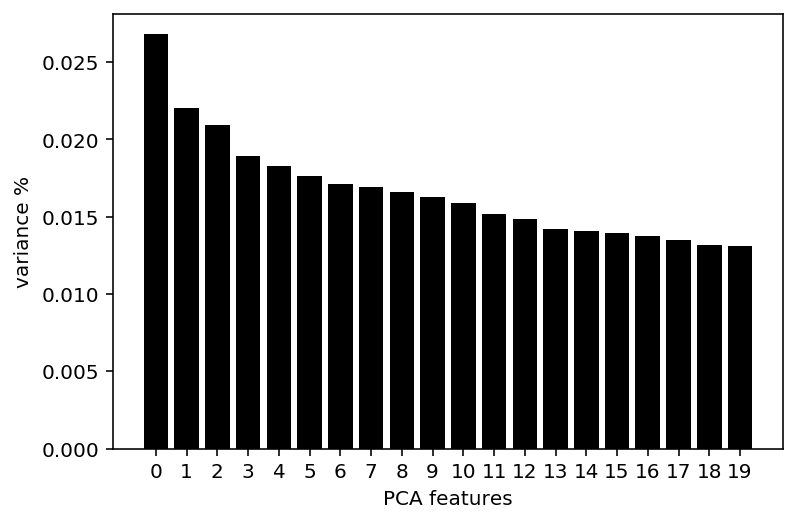

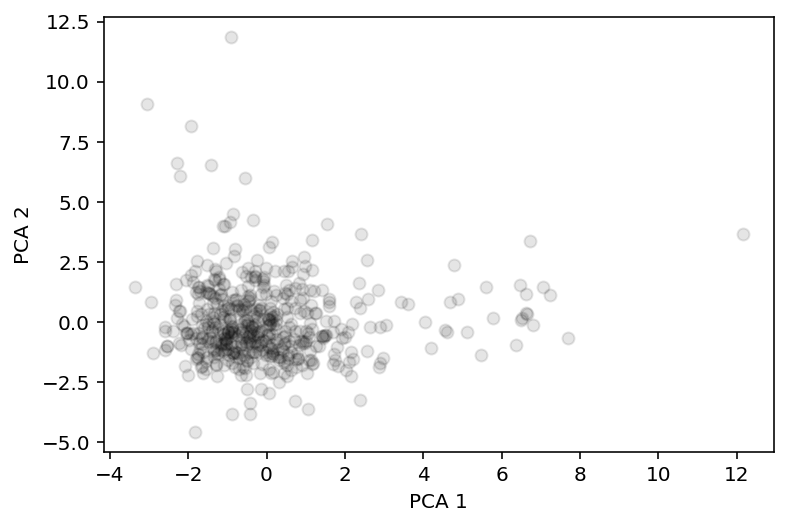

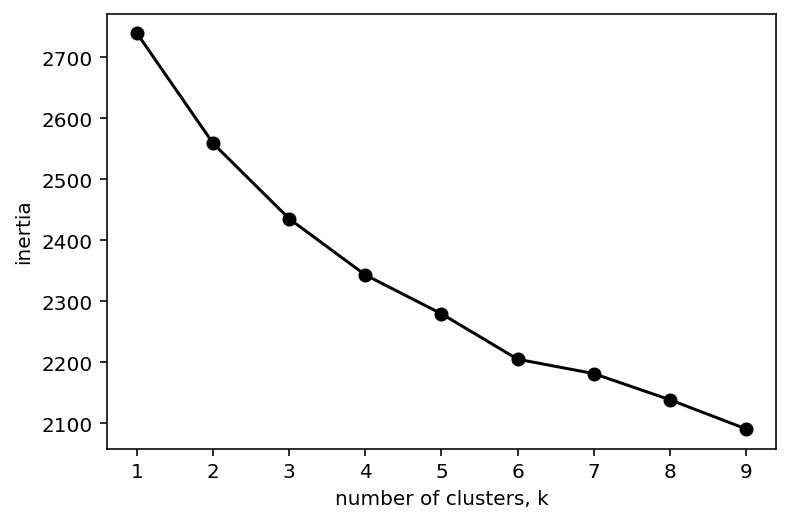

In [663]:
data_report = pca_kmeans_report(transformed_data)

**PCA analysis for simpler data:**

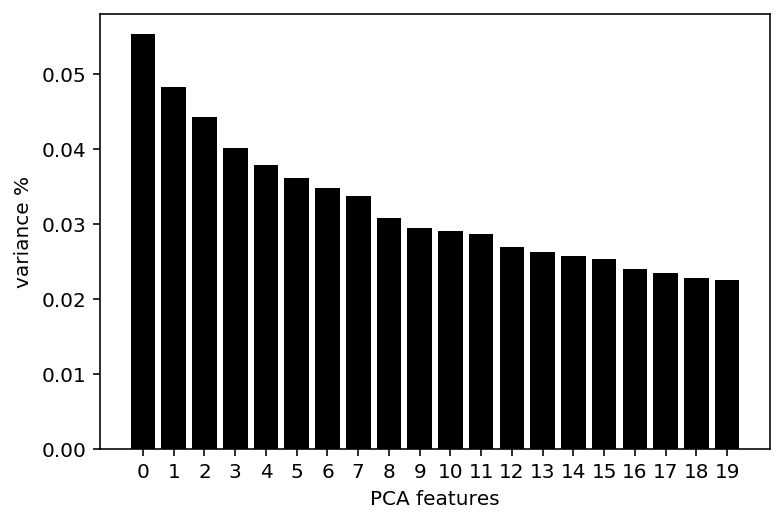

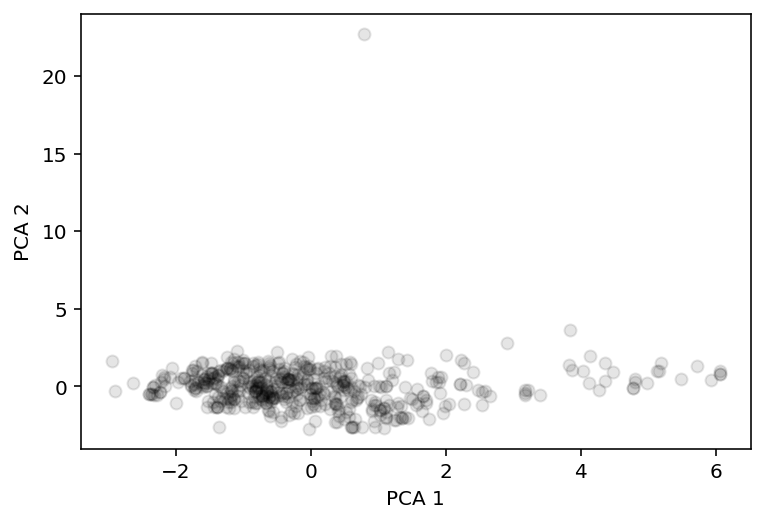

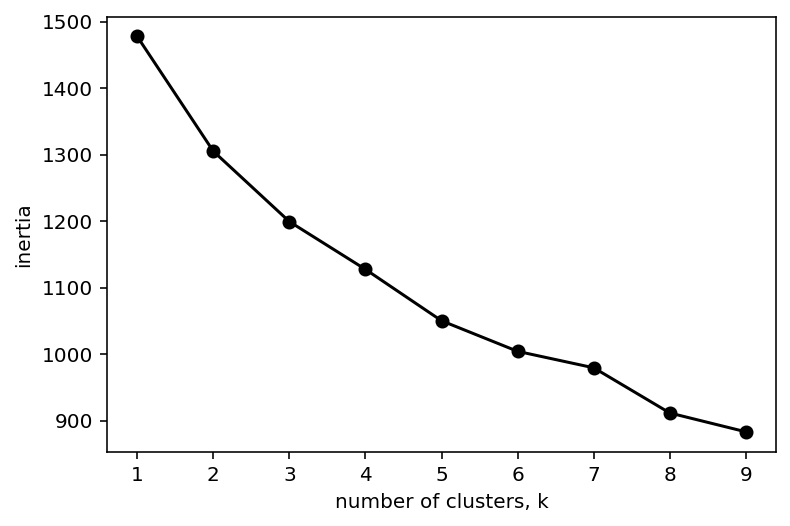

In [664]:
simpler_report = pca_kmeans_report(transformed_simpler)

**Scatter plot for both datas:**

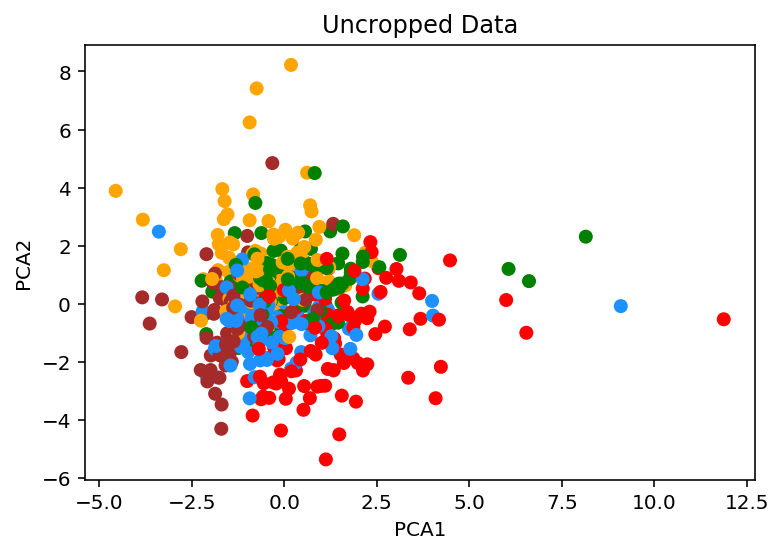

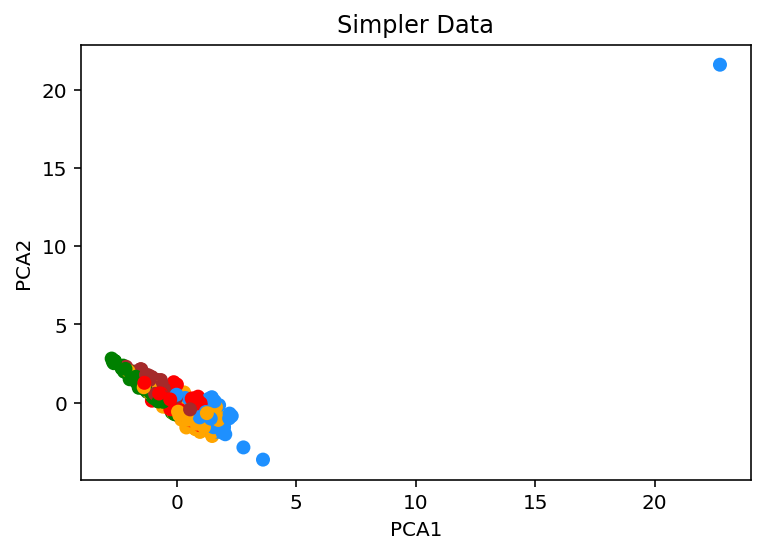

In [638]:
kmeans_data = KMeans(n_clusters=5).fit_predict(transformed_data)
kmeans_simpler = KMeans(n_clusters=5).fit_predict(transformed_simpler)
def plotKMeans(PCA_components, kmeans, graphName=""):
    color_dict = dict({0:'orange',
                      1:'green',
                      2: 'red',
                      3: 'dodgerblue',
                      4: 'brown',
                      5: 'gray',
                      6: 'magenta'})
    x = PCA_components.iloc[:,1].tolist()
    y = PCA_components.iloc[:,2].tolist()
    clust_color = [color_dict[l] for l in kmeans.tolist()]
    plt.scatter(x, y, marker='o', c = clust_color);
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title(graphName)
    plt.show()
plotKMeans(data_report, kmeans_data, "Uncropped Data")
plotKMeans(simpler_report, kmeans_simpler, "Simpler Data")

### Agnes Clustering

**Uncropped data:**

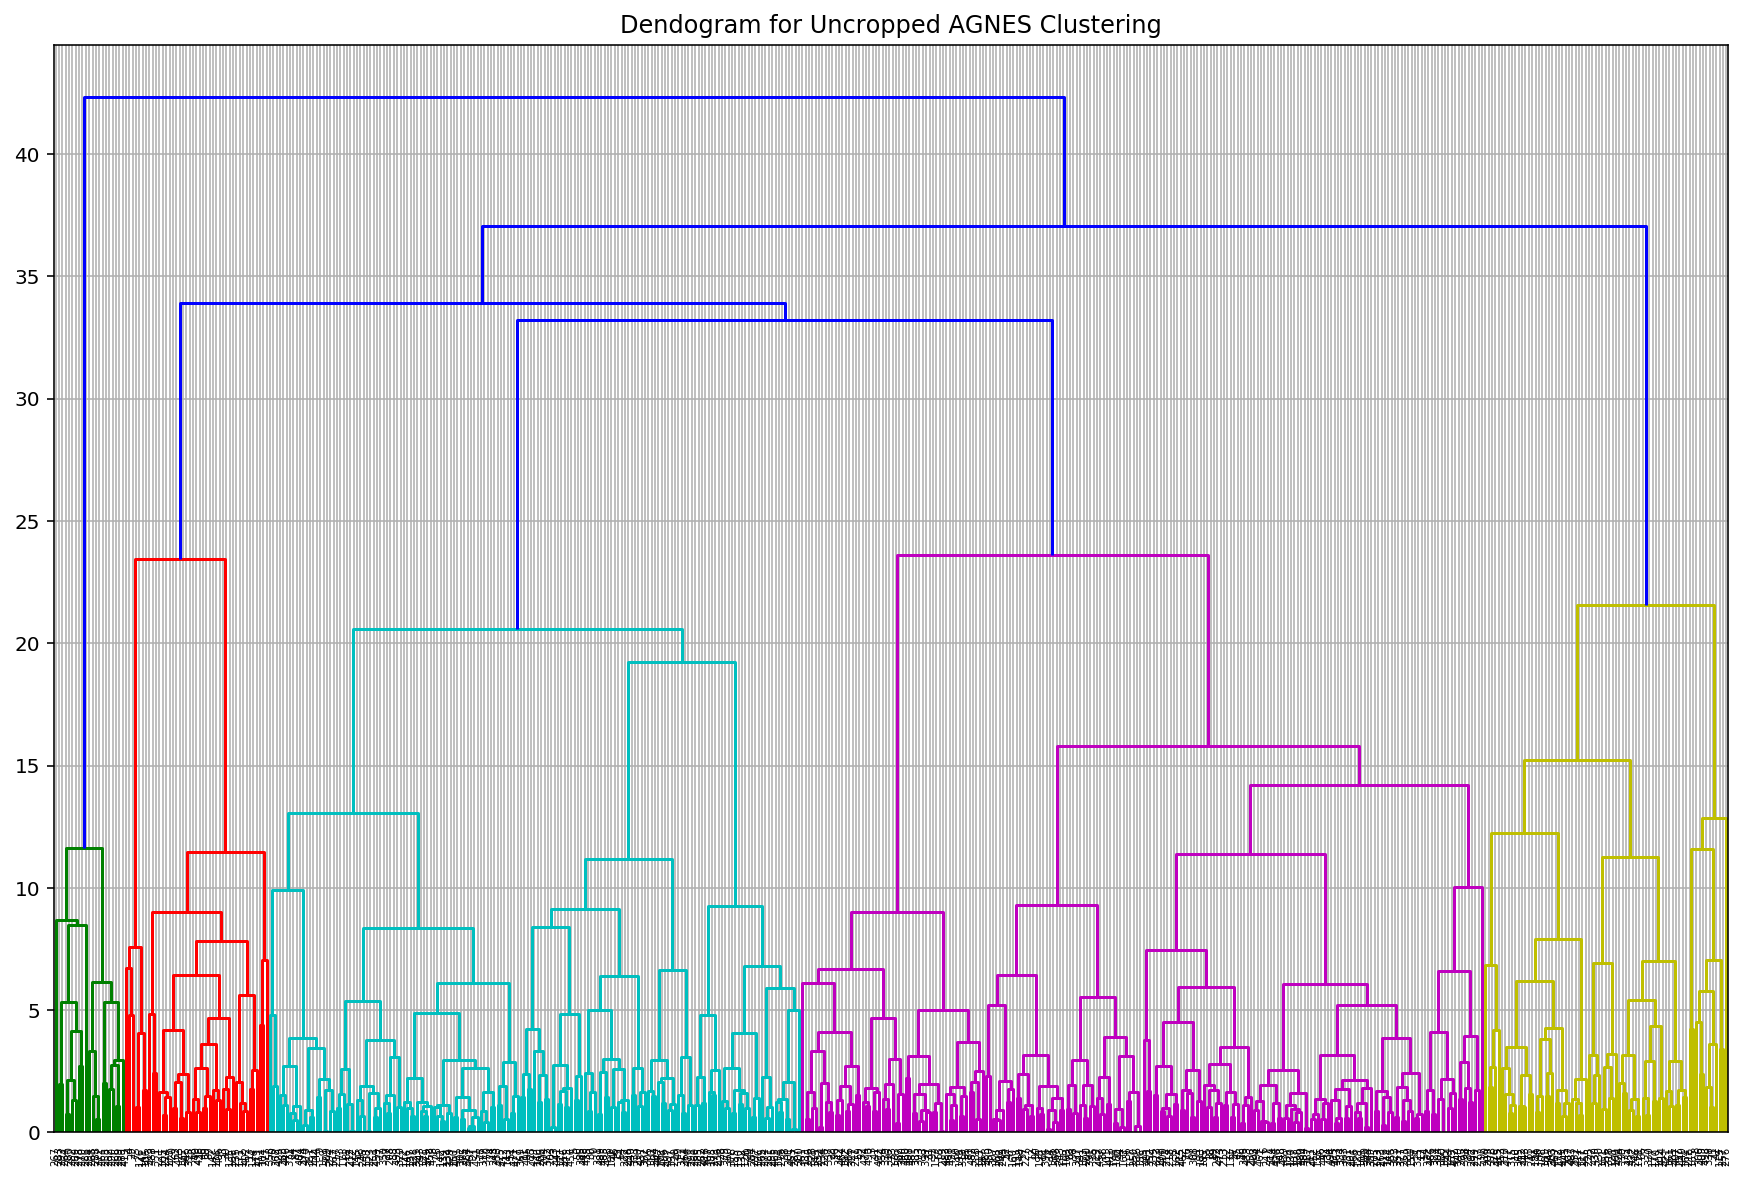

In [665]:
plt.figure(figsize =(15, 10)) 
pca_dimension = 5
plt.title('Dendogram for Uncropped AGNES Clustering') 
dendogram = shc.dendrogram((shc.linkage(data_report.iloc[:,:pca_dimension], method='ward',optimal_ordering=True)))
plt.grid()
plt.show()

**Simpler data:**

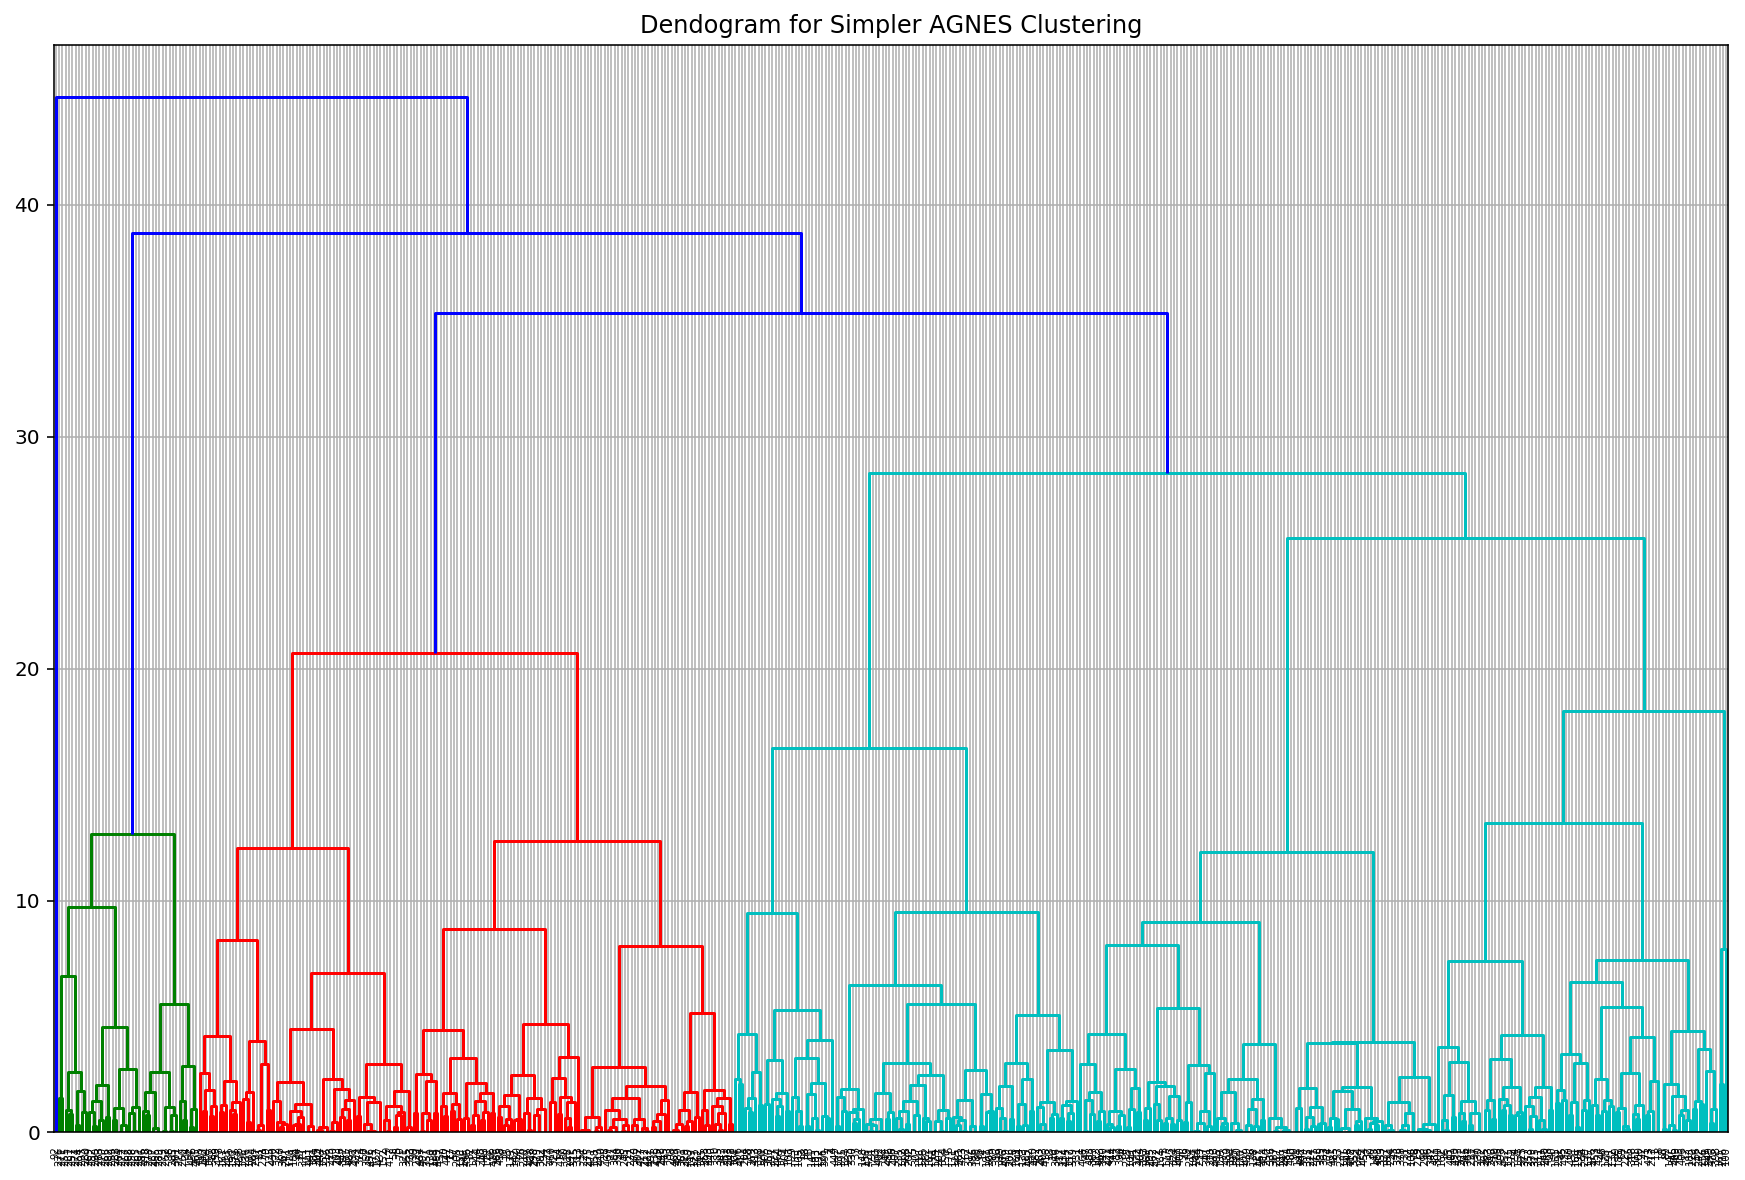

In [666]:
plt.figure(figsize =(15, 10))
plt.title('Dendogram for Simpler AGNES Clustering') 
dendogram = shc.dendrogram((shc.linkage(simpler_report.iloc[:,:pca_dimension], method='ward',optimal_ordering=True)))
plt.grid()
plt.show()

### DBSCAN Clustering

**Uncropped data:**

In [586]:
def plotDbscan(PCA_components, plotName=""):
    dbscan= DBSCAN(eps=0.5, min_samples=2).fit_predict(PCA_components)
    x = PCA_components[0]  # define the data
    y = PCA_components[1]  # define the data
    tag = dbscan
    
    color_dict = dict({-1:'gray',
                        0:'aliceblue',
                        1:'yellowgreen',
                        2:'antiquewhite',
                        3:'aqua',
                        4:'aquamarine',
                        5:'azure',
                        6:'beige',
                        7:'bisque',
                        8:'blanchedalmond',
                        9:'crimson',
                        10:'darkkhaki',
                        11:'forestgreen',
                        12:'fuchsia',
                        13:'gainsboro',
                        14:'ghostwhite',
                        15:'gold',
                        16:'goldenrod',
                        17:'black',
                        18:'ivory',
                        19:'khaki',
                        20:'lavender',
                        21:'lavenderblush',
                        22:'lawngreen',
                        23:'lemonchiffon',
                        24:'limegreen',
                        25:'linen',
                        26:'magenta',
                        27:'orchid',
                        28:'palegoldenrod',
                        29:'palegreen',
                        30:'purple',
                        31:'red',
                        32:'wheat',
                        33:'white',
                        34:'whitesmoke',
                        35:'yellow',
                        36:'magenta'})
    
    clust_color = []
    for l in tag.tolist():
        if(l == -1):
            clust_color.append([0,0,0,0.075])
            continue
        clust_color.append(color_dict[l])
    #print(clust_color)
    # make the scatter
    plt.scatter(x, y, c=clust_color)
    plt.title(plotName)
    a = plt.xlabel('PCA1')
    a = plt.ylabel('PCA2')
    plt.show

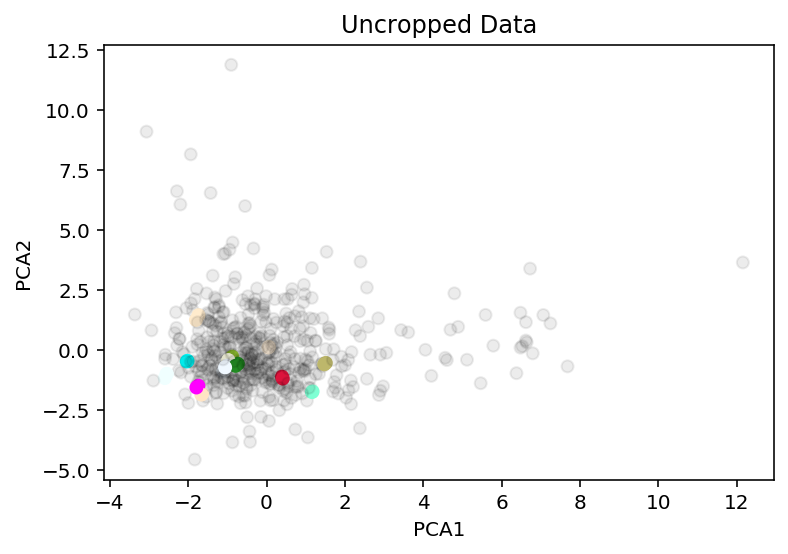

In [660]:
plotDbscan(data_report,"Uncropped Data")

**Simpler data:**

In [583]:
def plotDbscan_simp(PCA_components, plotName=""):
    dbscan= DBSCAN(eps=0.5, min_samples=2).fit_predict(PCA_components)
    x = PCA_components[0]  # define the data
    y = PCA_components[1]  # define the data
    tag = dbscan
    
    color_dict = dict({-1:'gray',
                        0:'aliceblue',
                        1:'yellowgreen',
                        2:'antiquewhite',
                        3:'aqua',
                        4:'aquamarine',
                        5:'azure',
                        6:'beige',
                        7:'bisque',
                        8:'blanchedalmond',
                        9:'crimson',
                        10:'darkkhaki',
                        11:'forestgreen',
                        12:'fuchsia',
                        13:'gainsboro',
                        14:'ghostwhite',
                        15:'gold',
                        16:'goldenrod',
                        17:'black',
                        18:'ivory',
                        19:'khaki',
                        20:'lavender',
                        21:'lavenderblush',
                        22:'lawngreen',
                        23:'lemonchiffon',
                        24:'limegreen',
                        25:'linen',
                        26:'magenta',
                        27:'orchid',
                        28:'palegoldenrod',
                        29:'palegreen',
                        30:'purple',
                        31:'red',
                        32:'wheat',
                        33:'white',
                        34:'whitesmoke',
                        35:'yellow',
                        36:'magenta',
                        37:'mistyrose',
                        38:'mediumturquoise',
                        39:'silver',
                        40:'snow',
                        41:'lime',
                        42:'mediumvioletred',
                        43:'mediumslateblue',
                        44:'saddlebrown',
                        45:'whitesmoke',
                        46:'sandybrown',
                        47:'yellowgreen',
                        48:'palegoldenrod',
                        49:'palegreen',
                        50:'purple',
                        51:'red',
                        52:'wheat',
                        53:'white',
                        54:'whitesmoke',
                        55:'yellow',
                        56:'magenta'})
        
    clust_color = []
    for l in tag.tolist():
        if(l == -1):
            clust_color.append([0,0,0,0.075])
            continue
        clust_color.append(color_dict[l])

    #print(clust_color)
    # make the scatter
    plt.scatter(x, y, c=clust_color)
    plt.title(plotName)
    a = plt.xlabel('PCA1')
    a = plt.ylabel('PCA2')
    plt.show()
#dbscan= DBSCAN(eps=0.5, min_samples=2).fit_predict(PCA_components)

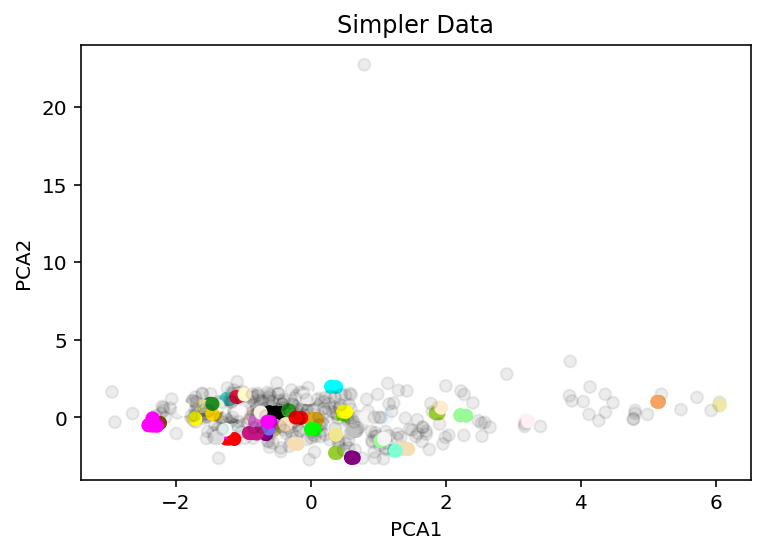

In [662]:
plotDbscan_simp(simpler_report, plotName="Simpler Data")